# Dimensionality Reduction, Feature Extaction, and Manifold Learning

__Import libraries__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

- Motivations of using unsupervised learning:
    - Visualization
    - Compressing the data
    - Finding a representation that is more informative for further processing.

---

## Principal Component Analysis (PCA)

- Principal component analysis is a method that rotates the dataset in a way such that the rotated features are statistically uncorrelated. Followed by selecting important features.

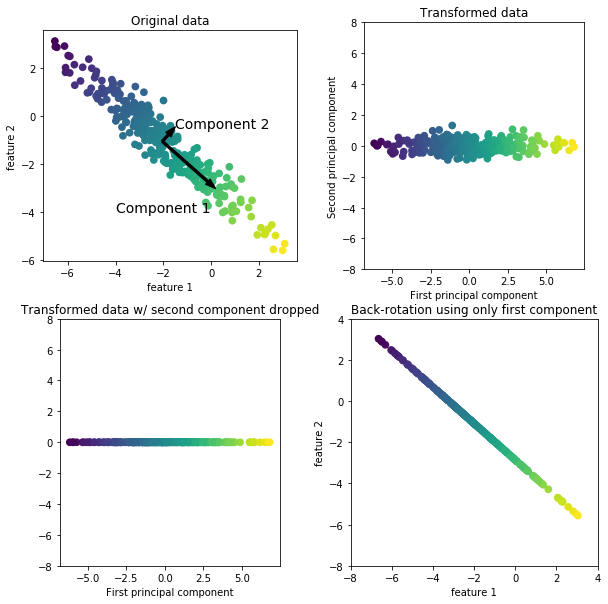

In [2]:
mglearn.plots.plot_pca_illustration()

- First, finding the direction of maximum variance. This direction or vector contains most of the information, or in other words, the direction along which the features are most correlated with each other.
- This directions found using this process are called principal components, as they are the main directions of variance in the data.
- Now rotate the data so the first principal component aligns with x-axis and the second principal component aligns with y-axis. Before that the data was transformed so the center is on 0 (scaling?).
- In the rotated representation found by PCA, the two axes are uncorrelated, meaning that the correlation matrix of the data in this representation is zero except for the diagonal.
- PCA reduces the data from a two-dimensional dataset to a one-dimensional dataset. In this case, we drop second principal component and keep first principal component.
- Finally, we can undo the rotation and add the mean back to the data.
- This transformation is sometimes used to remove noise effects from the data or visualize what part of the information is retained using the principal components.

### Applying PCA to the cancer dataset for visualization.

- Common application of using PCA is for visualizing high-dimensional datasets.

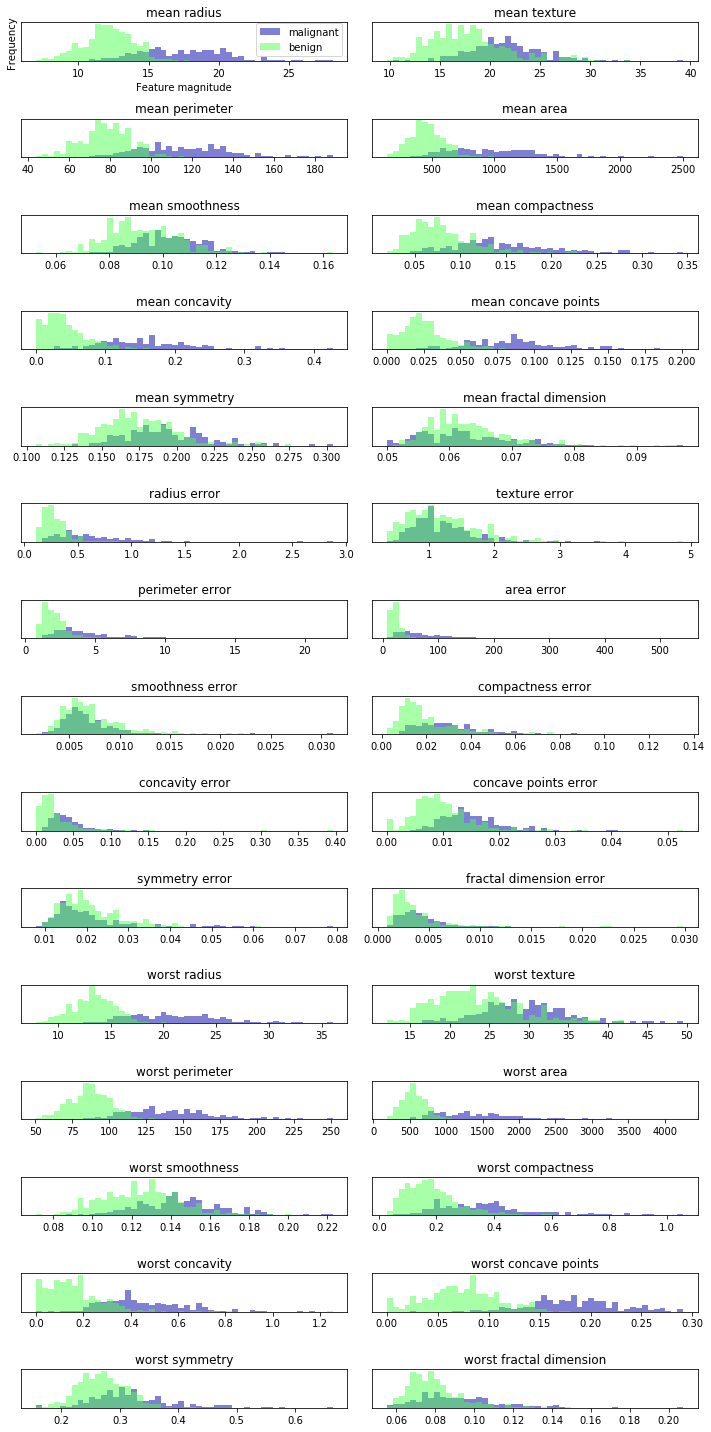

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=0.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()

Text(0.5, 1.0, 'Mean radius')

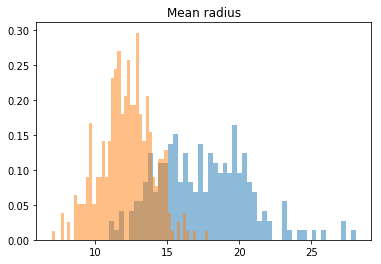

In [12]:
plt.hist(malignant[:, 0], bins=50, alpha=0.5, density=True)
plt.hist(benign[:, 0], bins=50, alpha=0.5, density=True)
plt.title('Mean radius')

- This gives us some idea of how each feature is distributed across the two classes, and allows us to venture a guess as to which features are better at distinguishing malignant and benign samples. For example, smoothness error does not give us better information to distinguish malignant and benign, and worst concave points is pretty informative because the histograms are quite disjoint.

In [3]:
# scale our data first
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

Learning the PCA transformation and applying it is as simple as applying a preprocessing
transformation. We instantiate the PCA object, find the principal components
by calling the fit method, and then apply the rotation and dimensionality reduction
by calling transform. By default, PCA only rotates (and shifts) the data, but keeps all
principal components. To reduce the dimensionality of the data, we need to specify
how many components we want to keep when creating the PCA object:

In [4]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=2)
# fit PCA model to breast cancer data
pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


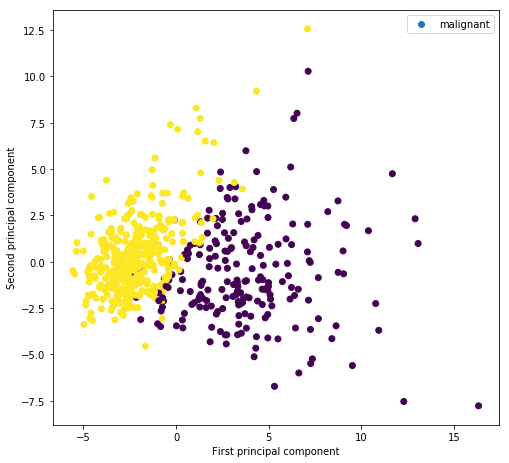

In [20]:
# plot first vs second principal components, colored by class
plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cancer.target)
plt.legend(cancer.target_names, loc='best')
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

- PCA is an unsupervied method, and does not use any class information when finding the rotation. 
- A downside of PCA is that the two axes in the plot are often not very easy to interpret. The principal components correspond to directions in the original data, so they are combinations of the original features.
- The principal components themselves are stored in the components_ attribute of the PCA object during fitting.

In [21]:
print("PCA component shape: {}".format(pca.components_.shape))

PCA component shape: (2, 30)


Each row in components_ corresponds to one principal component, and they are sorted
by their importance (the first principal component comes first, etc.). The columns
correspond to the original features attribute of the PCA in this example, “mean
radius,” “mean texture,” and so on.

In [22]:
print("PCA components:\n{}".format(pca.components_))

PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


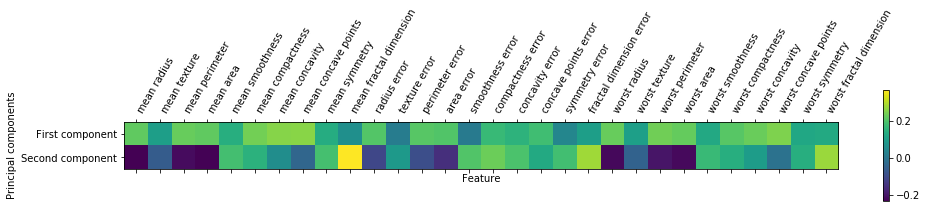

In [5]:
# visualize the coefficients using heatmap.
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),
            cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

### Eigenfaces for Feature Extraction

In [8]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people()

In [9]:
people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [11]:
people.data[:5]

array([[ 34.      ,  29.333334,  22.333334, ...,  14.666667,  16.      ,
         14.      ],
       [158.      , 160.66667 , 169.66667 , ..., 138.66667 , 135.33333 ,
        130.33333 ],
       [ 77.      ,  81.333336,  88.      , ..., 192.      , 145.33333 ,
         66.333336],
       [ 11.333333,  11.333333,  11.666667, ..., 118.      , 106.333336,
         92.333336],
       [ 32.333332,  31.333334,  31.333334, ...,  17.      ,  19.666666,
         22.666666]], dtype=float32)

In [13]:
type(people.target[0])

numpy.int64

In [14]:
people.target[0]

5360

In [17]:
people.images[0]

array([[ 34.      ,  29.333334,  22.333334, ...,  20.      ,  25.666666,
         30.666666],
       [ 37.333332,  32.      ,  25.333334, ...,  21.      ,  26.666666,
         32.      ],
       [ 33.333332,  32.333332,  40.333332, ...,  23.666666,  28.      ,
         35.666668],
       ...,
       [166.      ,  97.      ,  44.333332, ...,   9.666667,  14.333333,
         12.333333],
       [ 64.      ,  38.666668,  30.      , ...,  12.666667,  16.      ,
         14.      ],
       [ 30.666666,  29.      ,  26.333334, ...,  14.666667,  16.      ,
         14.      ]], dtype=float32)

In [21]:
print("people.data.shape: {}".format(people.data.shape))
print("people.images.shape: {}".format(people.images.shape))
print('people.target.shape: {}'.format(people.target.shape))

people.data.shape: (13233, 2914)
people.images.shape: (13233, 62, 47)
people.target.shape: (13233,)


- The idea behind feature extraction is that it is possible to find a representation of your data that is better suited to analysis than the raw representation you were given. A great example is image.
- Images are made up of pixels, usually stored as RGB intensities.

In [4]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [5]:
people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [7]:
print("data.shape: {}".format(people.data.shape))
print("images.shape: {}".format(people.images.shape))
print("target.shape: {}".format(people.target.shape))

data.shape: (3023, 5655)
images.shape: (3023, 87, 65)
target.shape: (3023,)


In [21]:
image_shape = people.images[0].shape

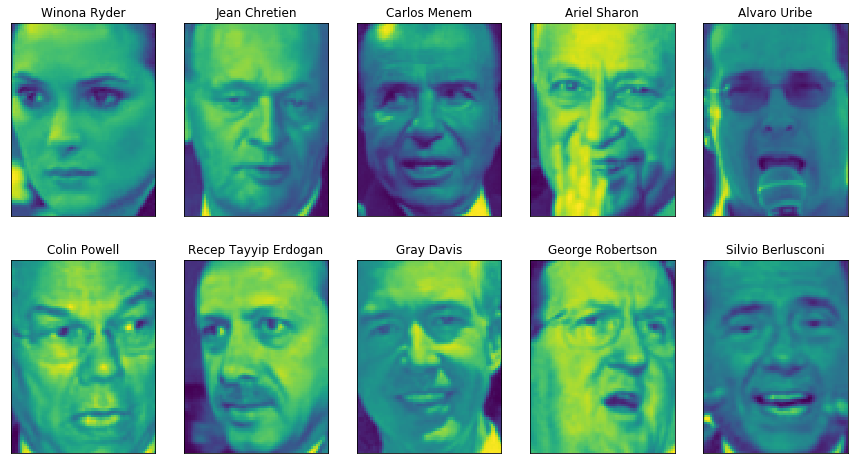

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks':(), 'yticks':()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

There are 3,023 images, each 87×65 pixels large, belonging to 62 different people:

In [23]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


The dataset is a bit skewed, containing a lot of images of George W. Bush and Colin Powell:

In [24]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

To make the data less skewed, we will only take up to 50 images of each person
(otherwise, the feature extraction would be overwhelmed by the likelihood of George
W. Bush):

In [25]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

In [26]:
mask = np.zeros(people.target.shape, dtype=np.bool)

In [69]:
np.where(people.target == 0)[0]

array([  58,   72,   90,  314,  494,  496,  598,  650,  960, 1078, 1212,
       1243, 1265, 1356, 1497, 1586, 1622, 1793, 1803, 1816, 1881, 1952,
       1962, 2003, 2068, 2179, 2183, 2239, 2373, 2441, 2510, 2535, 2622,
       2649, 2651, 2697, 2819, 2960, 2998], dtype=int64)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, random_state=0)

# instantiate the model
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
print("Test score accuracy with one neighbors: {:.3f}".format(knn.score(X_test, y_test)))

Test score accuracy with one neighbors: 0.283


Not a bad score for 62 class classification, a random guess will have 1.6% accuracy. But not good either.

This is where PCA comes in. Computing distances in the original pixel space is quite a bad way to measure similarity between faces. __When using a pixel representation to compare two images, we compare the grayscale value of each individual pixel to the value of the pixel in the corresponding position in the other image.__ This representation is quite different from how humans would interpret the image of a face, and it is hard to capture the facial features using this raw representation. For example, using pixel distances means that shifting a face by one pixel to the right corresponds to a drastic change, with a completely different representation. We hope that using distances along principal components can improve our accuracy. __Here, we enable the whitening option of PCA, which rescales the principal components to have the same scale.__ This is the same as using StandardScaler after the transformation. Reusing the data from Figure 3-3 again, whitening corresponds to not only rotating the data, but also rescaling it so that the center panel is a circle instead of an ellipse (see Figure 3-8):

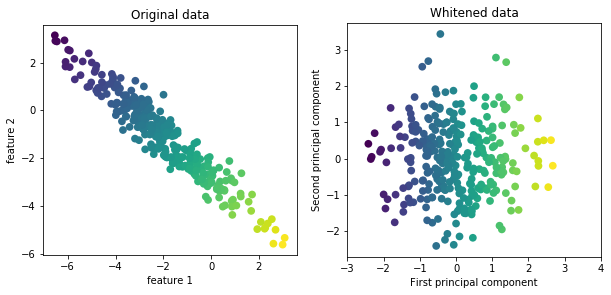

In [74]:
mglearn.plots.plot_pca_whitening()

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


In [36]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train_pca, y_train)
print("Test set accuracy: {:.3f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.328


Our accuracy improved quite significantly, from 28.3% to 32.8%, confirming our
intuition that the principal components might provide a better representation of the
data.

In [37]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


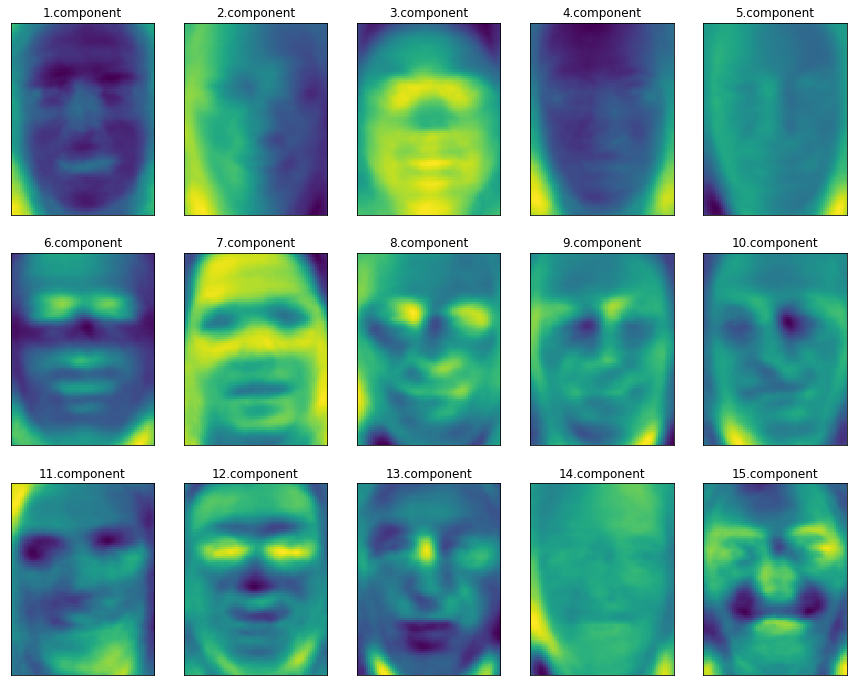

In [38]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks':(), 'yticks':()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}.component".format((i + 1)))

- First component seems to mostly encode the contrast between the face and the background, the second component encodes difference in lighting between the right and the left half of the face.
- This representation is highly more semantic than the raw pixel values.
- Recall: the PCA transformation as rotating and then dropping the components with low variance.
- Another useful interpretation is to try to find some numbers (the new feature values after the PCA rotation) so that we can express the test points as a weighted sum of the principal components.
- Here, x0, x1, and so on are the coefficients of the principal components for this data point; in other words, they are the representation of the image in the rotated space.

________________________________________________________________________________
[Memory] Calling mglearn.plot_pca.pca_faces...
pca_faces(array([[0.780392, ..., 0.091503],
       ...,
       [0.227451, ..., 0.930719]], dtype=float32), 
array([[0.069281, ..., 0.428758],
       ...,
       [0.159477, ..., 0.573856]], dtype=float32))
_______________________________________________________pca_faces - 12.9s, 0.2min


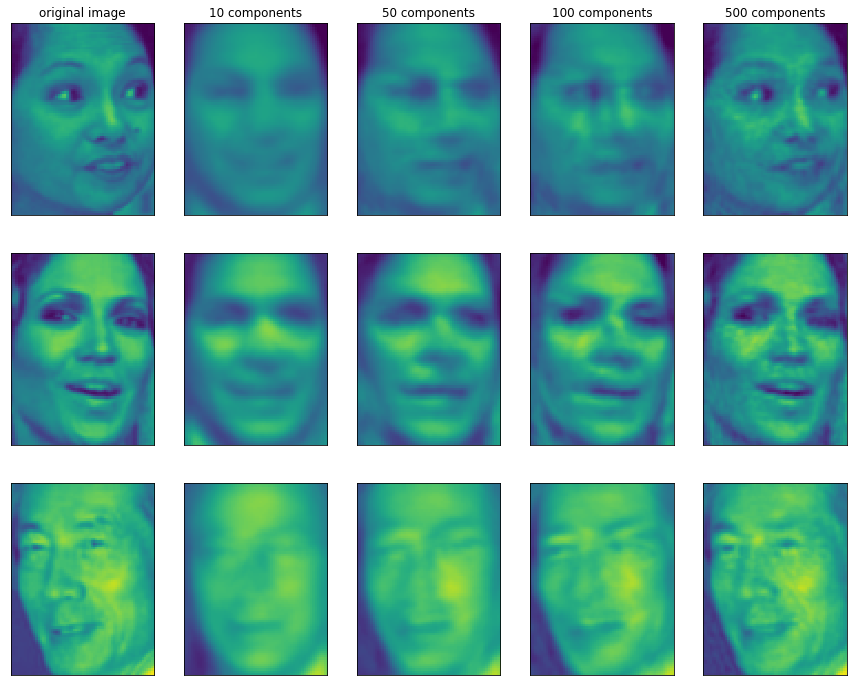

In [39]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

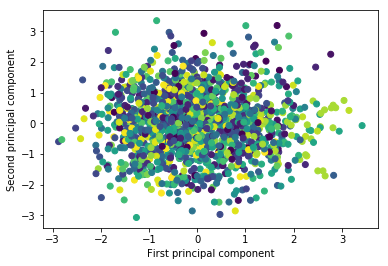

In [41]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

---

## Non-Negative Matrix Factorization (NMF)

- Aims to extract useful features.
- Can be used for dimensionality reduction.
- In PCA, we are trying to write each data point as a weighted sum of some components. We wanted the components that were orthogonal and that explained as much variance as possible.
- In NMF, we want the components and the coefficients to be non negative; that is, we want both the components and the coefficients to be greater than or equal to zero. Consequently, this method can only be applied to data where each feature is non-negative, as a non-negative sum of non-negative components cannot become negative.


### Applying NMF to synthetic data

- We need to ensure that our data is positive for NMF to be able to operate on the data.

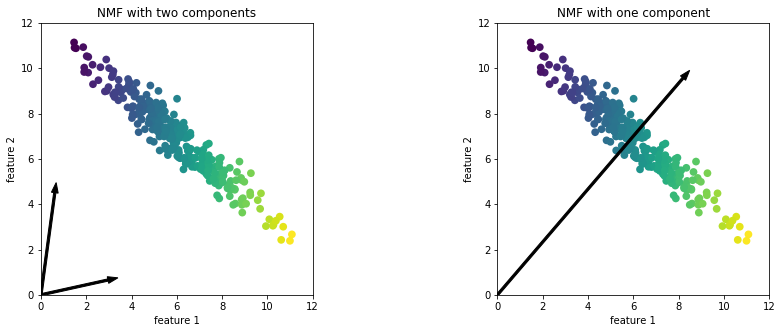

In [3]:
mglearn.plots.plot_nmf_illustration()

- Left, it is clear that all points in the data can be written as a positive combination of the two components. If there are enough components to perfectly reconstruct the data (as many components as there are features), the algorithm will choose directions that point toward the extremes of the data.
- Right, if we only use single component, NMF creates a component that points toward the mean, as pointing there best explains the data.
- Components in NNMF are also not ordered in any spesific way: all components play an equal part.
- NMF uses a random initialization. In simple data with low features, the randomization is subtle, but in complex data, there might be more drastic changes.

### Applying NMF to face images

- The main parameter of NMF is how many components we want to extract, usually this is lower than the number of input features.

In [44]:
# mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

- The quality of the back-transformed data is similar to when using PCA, but slightly worse.
- PCA finds the optimum directions in terms of reconstruction. 
- NMF is usually not used for its ability to reconstruct or encode data, but rather for finding interesting patterns within the data.

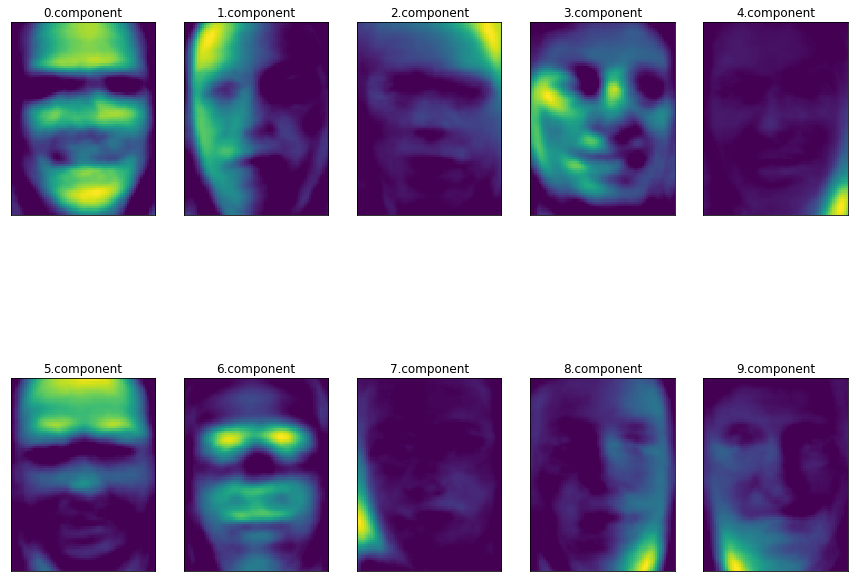

In [45]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, random_state=0).fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(2, 5, figsize=(15, 12), subplot_kw={'xticks':(), 'yticks':()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}.component".format(i))

- These components are all positive

---

## Manifold Learning with t-SNE

- PCA is often a good first approach for transforming data to visualize. But the nature of the method limits its usefulness.
- Manifold learning algorithm allow for much more complex mappings and often provsed better visualizations. A particularly useful one is the t-SNE algorithm
- Manifold learning algorithms are mainly aimed at visualization, t-SNE computes a new representation of the training data, but don't allow transformations of new data. Cannot applied to test set.
- Useful for exploratory data analysis, but rarely used if the final goal is supervised learning.
- The idea behind t-SNE is to find a two-dimensional representation of the data that preserves the distances between points as best as possible. t-SNE starts with a random twodimensional representation for each data point, and then tries to make points that are close in the original feature space closer, and points that are far apart in the original feature space farther apart. t-SNE puts more emphasis on points that are close by,rather than preserving distances between far-apart points. In other words, it tries to preserve the information indicating which points are neighbors to each other.

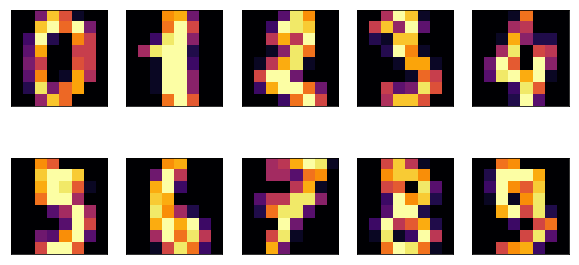

In [47]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':(), 'yticks':()})

for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img, cmap='inferno')

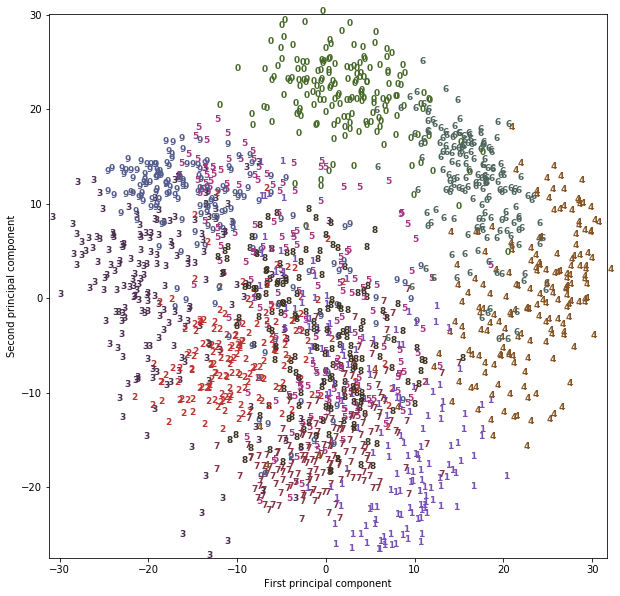

In [49]:
# build a PCA model, then transform it
pca = PCA(n_components=2, random_state=0).fit(digits.data)
digits_pca  = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]], fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

Text(0.5, 0, 't-SNE feature 1')

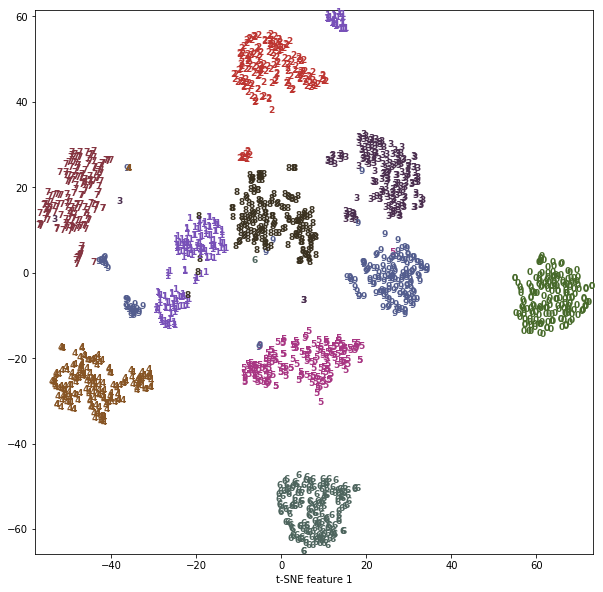

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
# no transform, use fit_transform instead of fit
digits_tsne = tsne.fit_transform(digits.data)
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 0")
plt.xlabel("t-SNE feature 1")

- This method has no knowledge of the class labels: it is completely unsupervised.
- Still, it can find a representation of the data in two dimensions that clearly separates the classes, based solely on how close points are in the original space.
- Known parameter: perplexity and early_exaggeration

---

# IMPORTANT POINTS: 

- Principal Component Analysis (PCA):
    - from sklearn.decomposition
    - Use for dimensionality reduction, to find principal component, component with high variance and contain much information.
    - Steps:
        - Find pricipal components
        - Standardize
        - Rotate
        - Drop the irrelevant component
        - Tranform back.
    - Parameter(s):
        - n_components: first n_components
    - Attribute(s):
        - pca.components_: shape (n_components, n_features)
    - Methods:
        - fit, ex: pca.fit(X_train)
        - transform, ex: pca.transform(X_train)
        - fit_transform, ex: pca.fit_transform(X_train)
    - Weakness(s):
        - Plotting with first two principal components is hard to interpret.
        - Using t-SNE is better.
- Non-Negative Matrix Factorization (NMF)
    - from sklearn.decomposition
    - Used for feature extraction, and can be used for dimensionality reduction.
    - Non-negative components and coefficients.
    - Applied only to non-negative features.
    - Used for finding interesting patterns within the data.
    - Parameter(s):
        - n_components
    - Methods:
        - fit, ex: nmf.fit(X_train)
        - transform, ex: nmf.transform(X_train)
        - fit_transform, ex: nmf.fit_transfrom(X_train)
- Manifold Learning:
    - One of it is t-SNE.
    - Mainly for data visualization.
    - Used for exploratory data analysis.
    - Not often used if the final goal is supervised learning.
    - Method(s):
        - fit_transform, ex: tsne.fit_transform(X)
        - Applied only for whole or training data, cannot to test set.
    - The idea behind t-SNE is make futher points further and closer points closer.
    - Find a two-dimensional representation of the data that preserves the distances between points as best as possible.